In [1]:
using Pkg
Pkg.activate("../")

using Revise
using MarkovModels

 Activating environment at `~/GithubRepositories/MarkovModels/Project.toml`
┌ Info: Precompiling MarkovModels [c2ae6250-d0a1-11ea-0991-234599ce5244]
└ @ Base loading.jl:1260


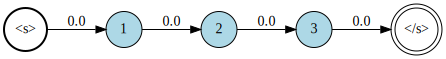

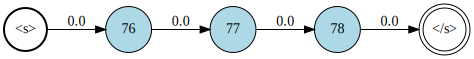

In [2]:
function makehmm(pdfidxs)
    fsm = FSM()
    prevstate = initstate(fsm)
    for pdfidx in pdfidxs
        state = addstate!(fsm, pdfindex = pdfidx)
        
        # We don't add the self loop here as it will be
        # removed by the minimization algorithms

        link!(fsm, prevstate, state)
        prevstate = state
    end
    link!(fsm, prevstate, finalstate(fsm))
    fsm |> weightnormalize!
end

hmms = Dict{Label, FSM}()
for (i, l) in enumerate('a':'z')
    startidx = 3 * (i -1) + 1
    hmms["$l"] = makehmm([startidx, startidx + 1, startidx + 2])
end
display(hmms["a"])
display(hmms["z"])

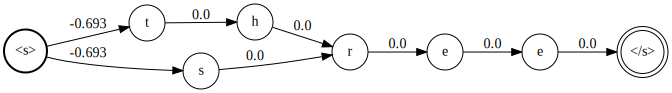

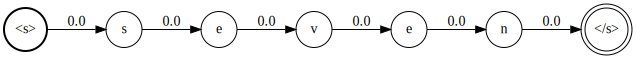

In [4]:
spelling = Dict(
    "zero"  => [("z", "e", "r", "o")],
    "one"   => [("o", "n", "e")],
    "two"   => [("t", "w", "o")],
    "three" => [("t", "h", "r", "e", "e"),
                ("s", "r", "e", "e")],  # French pronunciation 😁
    "four"  => [("f", "o", "u", "r")],
    "five"  => [("f", "i", "v", "e")],
    "six"   => [("s", "i", "x")],
    "seven" => [("s", "e", "v", "e", "n")],
    "eight" => [("e", "i", "g", "h", "t")],
    "nine"  => [("n", "i", "n", "e")]
)

function makepronunciation(pronunciation)
    fsm = FSM()
    prevstate = initstate(fsm)
    for letter in pronunciation
        state = addstate!(fsm, label = letter)
        link!(fsm, prevstate, state)
        prevstate = state
    end
    link!(fsm, prevstate, finalstate(fsm))
    fsm
end

lexicon = Dict{Label, FSM}()
for (word, pronunciations) in spelling
    lexicon[word] = union(makepronunciation.(pronunciations)...) |> minimize!
end

display(lexicon["three"])
display(lexicon["seven"])

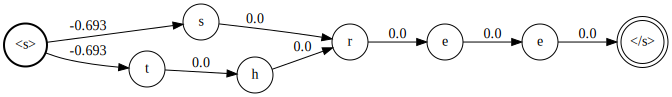

In [6]:
test = deepcopy(lexicon["three"])
test |> weightnormalize!

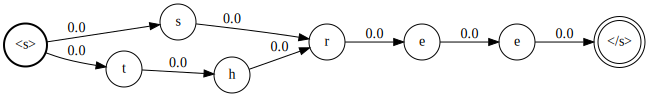

In [7]:
test = deepcopy(lexicon["three"])
determinize!(test)

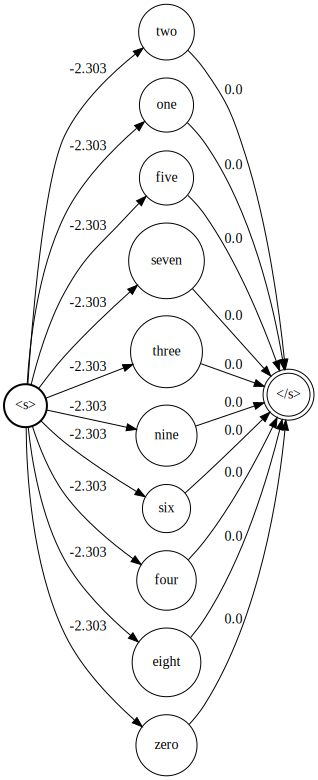

In [12]:
words = keys(lexicon)

# Create a simple unigram language model
lm = FSM()
for word in keys(lexicon)
    s = addstate!(lm, label = word)
    link!(lm, initstate(lm), s)
    link!(lm, s, finalstate(lm))
end

lm = lm |> weightnormalize!

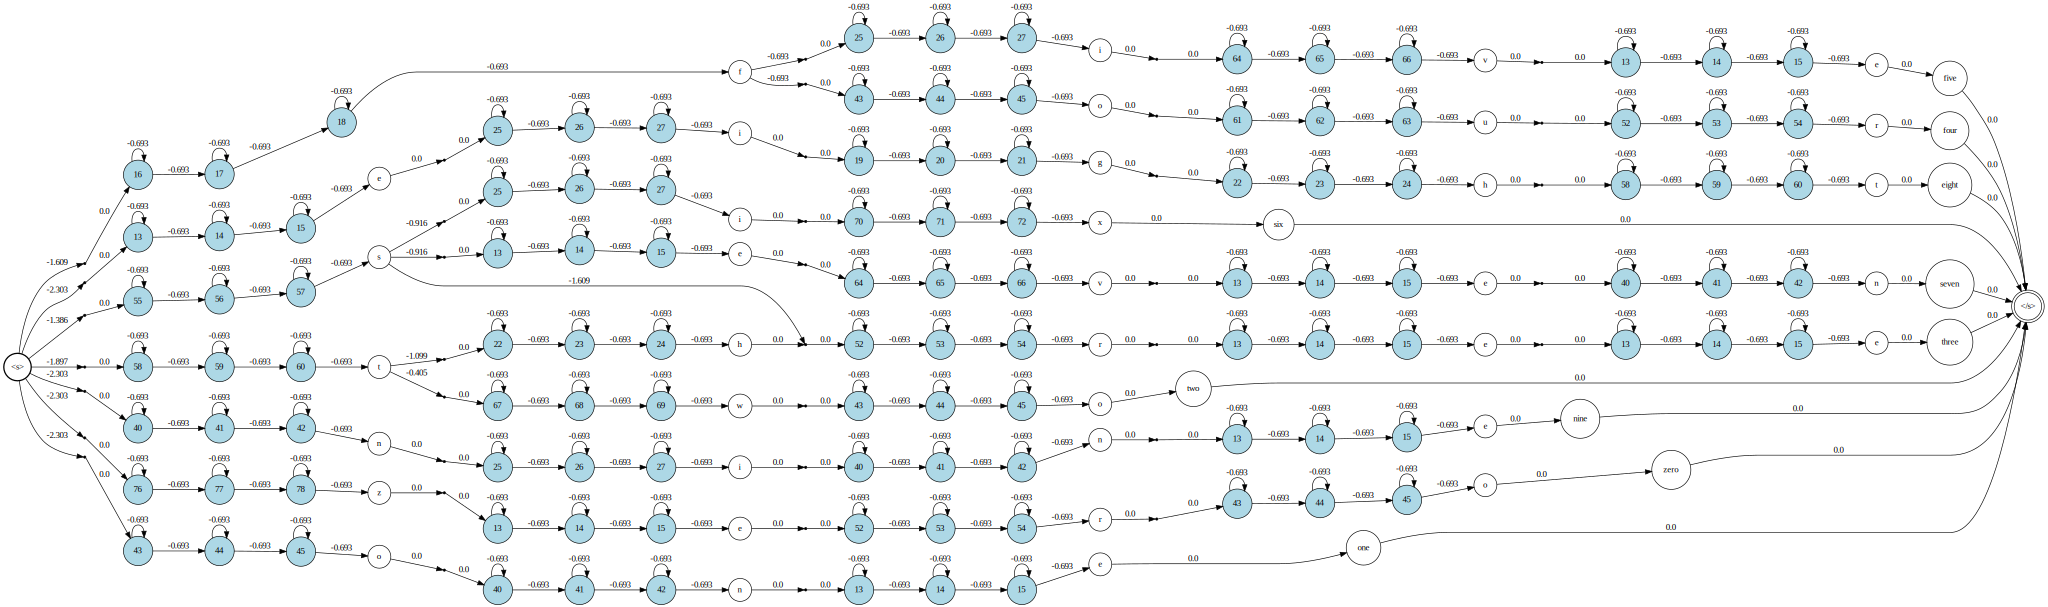

In [13]:
decoder = compose!(compose!(lm, lexicon) |> minimize!, hmms) |> addselfloop!

In [14]:
emissionsmap = Dict(
    "a" => 1,
    "b" => 2,
    "c" => 3,
    "d" => 4
)

fsm = FSM()
s1 = addstate!(fsm, pdfindex = 1)
s2 = addstate!(fsm, pdfindex = 2)
s3 = addstate!(fsm, pdfindex = 3)

link!(fsm, initstate(fsm), s1)
link!(fsm, s1, s2)
link!(fsm, s2, s3)
link!(fsm, s3, finalstate(fsm))

1-element Array{Link,1}:
 Link{Float64}(State(finalstateid), State(3, pdfindex = 3), 0.0)

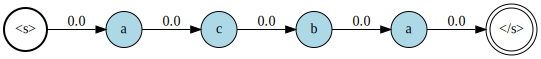

In [15]:
fsm1 = LinearFSM(["a", "c", "b", "a"], emissionsmap)

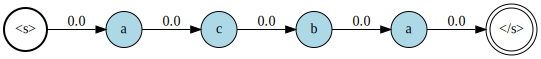

In [16]:
deepcopy(fsm1) |> determinize!

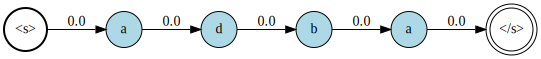

In [17]:
fsm2 = LinearFSM(["a", "d", "b", "a"], emissionsmap)

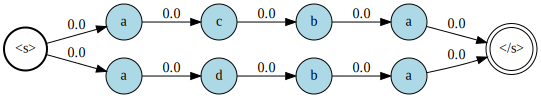

In [18]:
fsm = union(fsm1, fsm2)
fsm

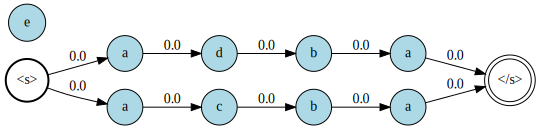

In [19]:
addstate!(fsm, pdfindex = 10, label = " e") # add unreachable state
fsm

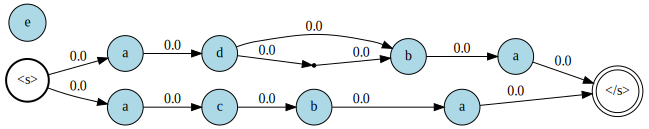

In [20]:
# Add useless connection
tmp = addstate!(fsm)
link!(fsm, fsm.states[6], tmp)
link!(fsm, tmp, fsm.states[7])
fsm

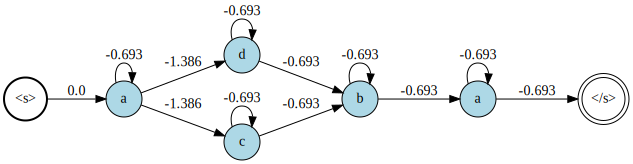

In [21]:
fsm = fsm |> minimize! |> addselfloop!

In [22]:
function pdfresps(lnαβ::Vector{<:Dict}, S::Int64)
    N = length(lnαβ)
    resps = zeros(S, N)
    for n in 1:N
        for (s, w) in lnαβ[n]
            resps[s.pdfindex, n] += exp(w)
        end
    end
    resps
end

function stateresps(lnαβ::Vector{<:Dict}, S::Int64)
    N = length(lnαβ)
    resps = zeros(S, N)
    for n in 1:N
        for (s, w) in lnαβ[n]
            resps[s.id, n] = exp(w)
        end
    end
    resps
end

stateresps (generic function with 1 method)

In [23]:
D,N = 4, 100 # number of distributions times number of frames
llh = randn(D, N)

4×100 Array{Float64,2}:
 -0.400179    1.16495   0.022339  …  -0.0256663  -0.967853  -1.23025
  0.389577    1.27104   0.18221      -1.18872    -1.46153   -1.11937
  0.0878289  -0.656517  0.670287     -0.364919   -0.345199  -0.3166
 -1.44729    -0.142813  0.756106     -0.433363   -0.90698    0.777815

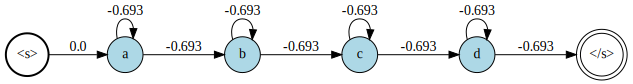

In [24]:
fsm1 = LinearFSM(["a", "b", "c", "d"], emissionsmap)
fsm1 |> addselfloop!

In [25]:
D,N = 4, 100 # number of distributions times number of frames
llh = randn(D, N)
fsm1 = LinearFSM(["a", "b", "c", "d"], emissionsmap)
lnα = αrecursion(fsm1 |> addselfloop!, 0*llh .+ 10) 
#heatmap(pdfresps(lnαβ, 4))

[n = 1]  	1	1 = 10.000  
[n = 2]  	1	1 = 19.307  	2 = 19.307  
[n = 3]  	2	1 = 28.614  	2 = 29.307  	3 = 28.614  
[n = 4]  	3	1 = 37.921  	2 = 39.019  	3 = 39.019  	4 = 37.921  
[n = 5]  	3	1 = 47.227  	2 = 48.614  	3 = 49.019  	4 = 48.614  
[n = 6]  	3	1 = 56.534  	2 = 58.144  	3 = 58.837  	4 = 58.837  
[n = 7]  	4	1 = 65.841  	2 = 67.633  	3 = 68.549  	4 = 68.837  
[n = 8]  	4	1 = 75.148  	2 = 77.094  	3 = 78.192  	4 = 78.703  
[n = 9]  	4	1 = 84.455  	2 = 86.534  	3 = 87.787  	4 = 88.480  
[n = 10]  	4	1 = 93.762  	2 = 95.959  	3 = 97.345  	4 = 98.192  
[n = 11]  	4	1 = 103.069  	2 = 105.371  	3 = 106.875  	4 = 107.856  
[n = 12]  	4	1 = 112.375  	2 = 114.773  	3 = 116.383  	4 = 117.481  
[n = 13]  	4	1 = 121.682  	2 = 124.167  	3 = 125.872  	4 = 127.076  
[n = 14]  	4	1 = 130.989  	2 = 133.554  	3 = 135.346  	4 = 136.645  
[n = 15]  	4	1 = 140.296  	2 = 142.935  	3 = 144.807  	4 = 146.193  
[n = 16]  	4	1 = 149.603  	2 = 152.311  	3 = 154.257  	4 = 155.723  
[n = 17]  	4	1 = 158.91

┌ Warning: `sort(d::Dict; args...)` is deprecated, use `sort!(OrderedDict(d); args...)` instead.
│   caller = ip:0x0
└ @ Core :-1


In [26]:
D,N = 4, 100 # number of distributions times number of frames
llh = randn(D, N)
fsm1 = LinearFSM(["a", "b", "c", "d"], emissionsmap)
lnβ = βrecursion(fsm1 |> addselfloop!, 0*llh .+10) 
#heatmap(pdfresps(lnαβ, 4))

[n = 1]  	1	1 = 933.341  	2 = 929.865  	3 = 925.974  	4 = 921.378  
[n = 2]  	1	1 = 924.004  	2 = 920.538  	3 = 916.657  	4 = 912.072  
[n = 3]  	1	1 = 914.666  	2 = 911.211  	3 = 907.339  	4 = 902.765  
[n = 4]  	1	1 = 905.328  	2 = 901.883  	3 = 898.022  	4 = 893.458  
[n = 5]  	1	1 = 895.989  	2 = 892.555  	3 = 888.705  	4 = 884.151  
[n = 6]  	1	1 = 886.650  	2 = 883.227  	3 = 879.387  	4 = 874.844  
[n = 7]  	1	1 = 877.311  	2 = 873.899  	3 = 870.070  	4 = 865.537  
[n = 8]  	1	1 = 867.971  	2 = 864.570  	3 = 860.752  	4 = 856.230  
[n = 9]  	1	1 = 858.631  	2 = 855.241  	3 = 851.434  	4 = 846.924  
[n = 10]  	1	1 = 849.291  	2 = 845.912  	3 = 842.117  	4 = 837.617  
[n = 11]  	1	1 = 839.950  	2 = 836.583  	3 = 832.799  	4 = 828.310  
[n = 12]  	1	1 = 830.609  	2 = 827.253  	3 = 823.480  	4 = 819.003  
[n = 13]  	1	1 = 821.267  	2 = 817.923  	3 = 814.162  	4 = 809.696  
[n = 14]  	1	1 = 811.925  	2 = 808.593  	3 = 804.844  	4 = 800.389  
[n = 15]  	1	1 = 802.583  	2 = 799.263  	3 

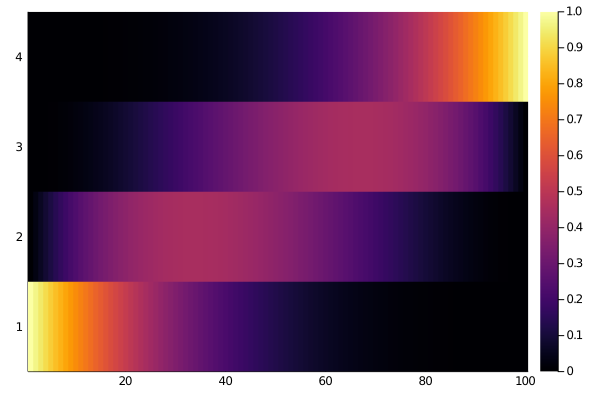

In [27]:
using Plots
D,N = 4, 100 # number of distributions times number of frames
llh = randn(D, N)
fsm1 = LinearFSM(["a", "b", "c", "d"], emissionsmap)
lnαβ, tll = αβrecursion(fsm1 |> addselfloop!, 0 * llh .+ 10) 
heatmap(pdfresps(lnαβ, 4))

In [28]:
lnαβ, tll = αβrecursion(fsm, llh) # the lower the more pruning 
pdfresps(lnαβ, length(emissionsmap))


4×100 Array{Float64,2}:
 1.0  0.846463   0.76843      0.675764    …  0.246268    0.716328  1.0
 0.0  0.0        0.000181583  0.00270538     0.753642    0.283672  0.0
 0.0  0.0617746  0.0757568    0.147753       1.37239e-5  0.0       0.0
 0.0  0.0917628  0.155632     0.173777       7.5951e-5   0.0       0.0

In [29]:
using Plots

In [30]:
llh = zeros(4,5)

4×5 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

In [31]:
llh[:,1:2] .= [1, 0.5, 0, 0]
llh[:,3:4] .= [0.5, 1, 0.5, 0]
llh[:,5:5] .= [0, 0.5, 1, 0.5]
llh

4×5 Array{Float64,2}:
 1.0  1.0  0.5  0.5  0.0
 0.5  0.5  1.0  1.0  0.5
 0.0  0.0  0.5  0.5  1.0
 0.0  0.0  0.0  0.0  0.5

In [32]:
α = αrecursion(fsm, llh; pruning = nopruning) # the lower the more pruning 

[n = 1]  	23	23 = 1.000  
[n = 2]  	23	20 = -0.386  	21 = -0.386  	23 = 1.307  
[n = 3]  	23	19 = 0.614  	20 = 0.734  	21 = 0.234  	23 = 1.114  
[n = 4]  	19	18 = 0.421  	19 = 1.954  	20 = 1.089  	21 = 0.332  	23 = 0.921  
[n = 5]  	19	18 = 1.456  	19 = 2.243  	20 = 1.749  	21 = 0.781  	23 = 0.227  


In [33]:
β = βrecursion(fsm, llh; pruning = nopruning) # the lower the more pruning 
β

[n = 1]  	20	18 = -0.773  	19 = 0.676  	20 = 0.926  	21 = 0.882  	23 = 0.456  
[n = 2]  	20	18 = -1.079  	19 = 0.601  	20 = 0.715  	21 = 0.601  	23 = -0.799  
[n = 3]  	19	18 = -0.886  	19 = 0.088  	20 = -0.386  	21 = -0.386  
[n = 4]  	19	18 = -0.693  	19 = -0.693  
[n = 5]  	18	18 = 0.000  


In [34]:
lnαβ, tll = αβrecursion(fsm, llh) # the lower the more pruning 
lnαβ

[n = 1]  	23	23 = 0.000  
[n = 2]  	23	20 = -1.128  	21 = -1.242  	23 = -0.948  
[n = 3]  	19	19 = -0.755  	20 = -1.109  	21 = -1.609  
[n = 4]  	19	18 = -1.729  	19 = -0.195  
[n = 5]  	18	18 = 0.000  


In [35]:
lnαβ, tll = αβrecursion(fsm, llh) # the lower the more pruning 
lnαβ

[n = 1]  	23	23 = 0.000  
[n = 2]  	23	20 = -1.128  	21 = -1.242  	23 = -0.948  
[n = 3]  	19	19 = -0.755  	20 = -1.109  	21 = -1.609  
[n = 4]  	19	18 = -1.729  	19 = -0.195  
[n = 5]  	18	18 = 0.000  


State[State(18, pdfindex = 1, label = a)]
[0.7633478691806482]
-----
State[State(19, pdfindex = 2, label = b), State(18, pdfindex = 1, label = a)]
[0.5680056089327146, -0.9657359027997263]
-----
State[State(21, pdfindex = 4, label = d), State(19, pdfindex = 2, label = b), State(20, pdfindex = 3, label = c)]
[-0.8456213958414489, -0.4657359027997262, -0.3456213958414489]
-----
State[State(23, pdfindex = 1, label = a), State(20, pdfindex = 3, label = c)]
[-0.6588830833596715, -1.6588830833596717]
-----
State[State(23, pdfindex = 1, label = a)]
[-0.6588830833596715]
-----


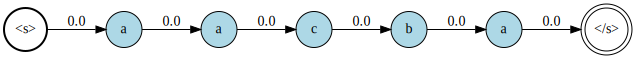

In [36]:
path = viterbi(fsm, llh)